In [ ]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import model_selection
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import re
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Problem 2) Cifar-10 dataset  

### Loading data and selecting subset of three classes

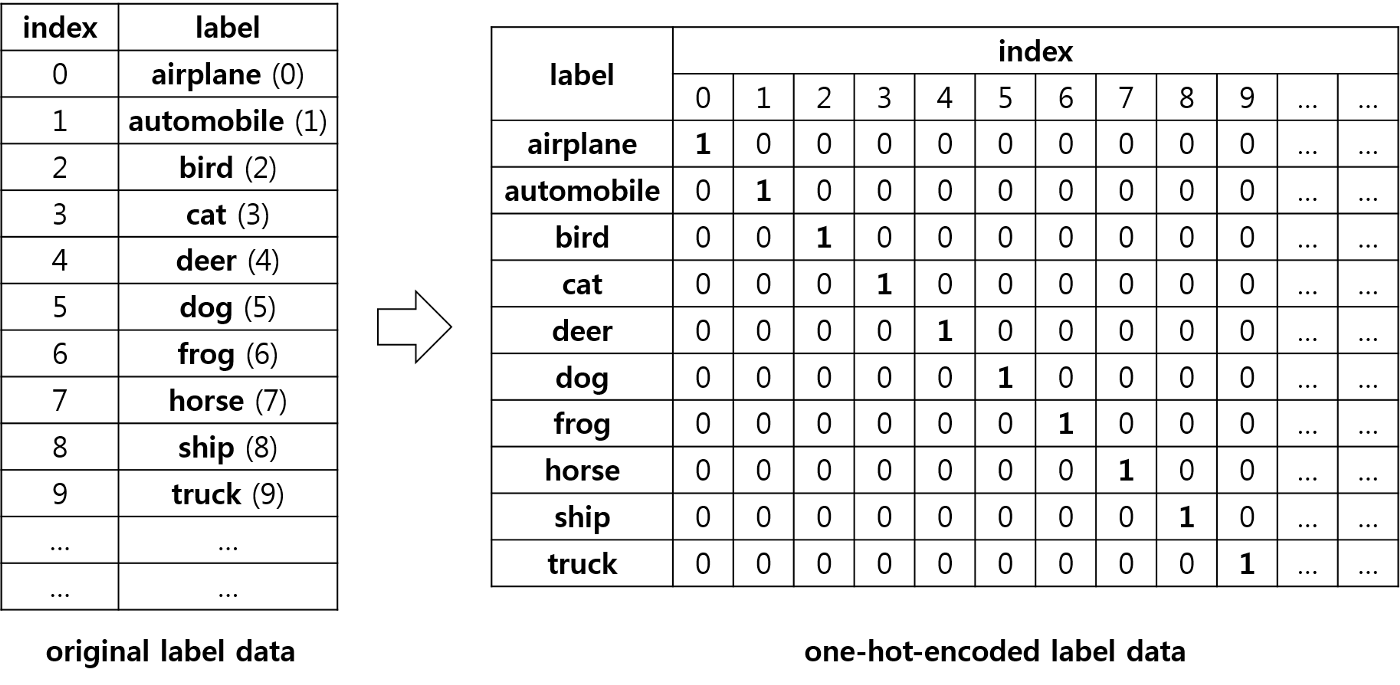

For this example, we're going to choose the labels, 0, 1, and 5 so it'll be airplane, automobile and dogs

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 16s 0us/step


In [ ]:
# Picking random 3 classes

random_classes = [0,1,5]

def sample_subset(X, y, random_classes=random_classes):

    def unison_shuffled_copies(a, b):
        '''This function is to shuffled two numpy arrays in unison'''
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    assert len(random_classes) == 3, 'Number of random classes must be three for this situation'

    class_x_tot = []
    class_y_tot = []
    for label in random_classes:
        class_x_tot.append(np.take(X, np.where(y==label)[0], axis=0))
        class_y_tot.append(np.take(y, np.where(y==label)[0], axis=0))
    
    X = np.concatenate((class_x_tot[0], class_x_tot[1], class_x_tot[2]))
    y = np.concatenate((class_y_tot[0], class_y_tot[1], class_y_tot[2]))

    X, y = unison_shuffled_copies(X, y)
    return X, y

#training set
x_train, y_train = sample_subset(x_train, y_train)

#testing set
x_test, y_test = sample_subset(x_test, y_test)

### Splitting data into training, validation, and test sets

In [ ]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size = .20, random_state=1)

In [ ]:
def shapes():
    print(f'X Train set: {np.shape(x_train)}\nY Train set: {np.shape(y_train)}\n\nX Val set: {np.shape(x_val)}\nY val set: {np.shape(y_val)}\n\nX Test set: {np.shape(x_test)}\nY Test set: {np.shape(y_test)}')

shapes()

X Train set: (12000, 32, 32, 3)
Y Train set: (12000, 1)

X Val set: (3000, 32, 32, 3)
Y val set: (3000, 1)

X Test set: (3000, 32, 32, 3)
Y Test set: (3000, 1)


Idea for vectorization:
1. Take the mean of the color channel
2. Divide by 255 to normalize (this should reduce it down to 32, 32 solely)
3. Reshape array to go from 32 x 32 dimension to one dimension (32*32 = 1024) in length
4. Pass this in to the network with input_shape = (32 * 32)

In [ ]:
def vectorize(arr):
    # take mean of color channels and normalize by dividing by 255.
    arr = np.mean(arr, axis=3) / 255.

    #reshape it to go from 2 dimensions (32 x 32) to one dimension of 1024 (32*32)
    arr = arr.reshape((len(arr), (np.shape(arr)[1] * np.shape(arr)[2])))

    #return arr
    return arr

In [ ]:
# run the function vectorize over all the x data
print(f'---------------Shape before----------------')
shapes()

x_train = vectorize(x_train)
x_val = vectorize(x_val)
x_test = vectorize(x_test)
print(f'---------------Shape after----------------')
shapes()

---------------Shape before----------------
X Train set: (12000, 32, 32, 3)
Y Train set: (12000, 1)

X Val set: (3000, 32, 32, 3)
Y val set: (3000, 1)

X Test set: (3000, 32, 32, 3)
Y Test set: (3000, 1)
---------------Shape after----------------
X Train set: (12000, 1024)
Y Train set: (12000, 1)

X Val set: (3000, 1024)
Y val set: (3000, 1)

X Test set: (3000, 1024)
Y Test set: (3000, 1)


In [ ]:
def vectorize_y(arr):
    '''Prepares labels for training'''
    # Need to change the labels from 0,1,5 to 0,1,2 to ensure proper categorical encoding
    arr[arr==5]=2

    #now utilize to_categorical and return it
    return tf.keras.utils.to_categorical(arr)


In [ ]:
print(f'---------------Shape before----------------')
shapes()

y_val = vectorize_y(y_val)
y_test = vectorize_y(y_test)
y_train = vectorize_y(y_train)
print(f'---------------Shape after----------------')
shapes()

---------------Shape before----------------
X Train set: (12000, 1024)
Y Train set: (12000, 1)

X Val set: (3000, 1024)
Y val set: (3000, 1)

X Test set: (3000, 1024)
Y Test set: (3000, 1)
---------------Shape after----------------
X Train set: (12000, 1024)
Y Train set: (12000, 3)

X Val set: (3000, 1024)
Y val set: (3000, 3)

X Test set: (3000, 1024)
Y Test set: (3000, 3)


In [ ]:
y_val

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

### Making Neural Network

In [ ]:
def model():
    model = tf.keras.models.Sequential()

    #input dense layer, relu activation, 32*32 input_shape
    model.add(layers.Dense(512, activation='relu', input_shape=(32*32,)))

    #next layer, hidden layer with 100 neurons, relu activation
    model.add(layers.Dense(256, activation='relu'))

    #another layer, hidden layer with 56 neurons, relu activation
    model.add(layers.Dense(56, activation='relu'))

    #final output layer, activation is softmax
    model.add(layers.Dense(3, activation='softmax'))

    return model




In [ ]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 56)                14392     
                                                                 
 dense_3 (Dense)             (None, 3)                 171       
                                                                 
Total params: 670,691
Trainable params: 670,691
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the network
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
#fit the network
history = model.fit(x=x_train, y=y_train, verbose=1, batch_size=128, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
94/94 [==============================] - 4s 6ms/step - loss: 1.1076 - accuracy: 0.4561 - val_loss: 1.1253 - val_accuracy: 0.4453
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 0.9401 - accuracy: 0.5566 - val_loss: 0.8490 - val_accuracy: 0.6013
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.8496 - accuracy: 0.6087 - val_loss: 0.9677 - val_accuracy: 0.5410
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.8070 - accuracy: 0.6325 - val_loss: 0.8424 - val_accuracy: 0.6227
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.7713 - accuracy: 0.6554 - val_loss: 0.8182 - val_accuracy: 0.5913
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.7455 - accuracy: 0.6741 - val_loss: 0.7714 - val_accuracy: 0.6500
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.7196 - accuracy: 0.6839 - val_loss: 0.8703 - val_accuracy: 0.5887
Epoch 8/100
9

We achieved training accuracies of around 95% and validation accuracies of around 76.30%. We can do better most likely by simply changing the loss function and optimizier

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
def generate_plots(history):
    #accuracies
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

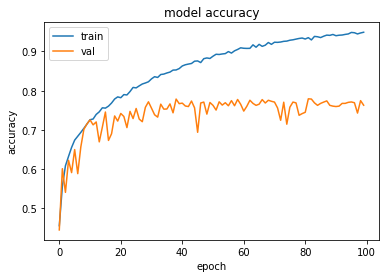

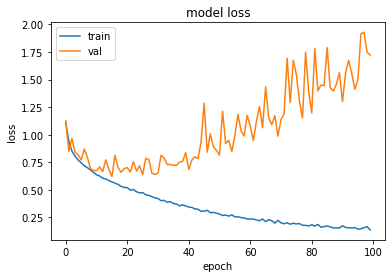

In [ ]:
generate_plots(history=history)

In [ ]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 1.3727 - accuracy: 0.7703


[1.3727195262908936, 0.7703333497047424]

For this model we recieved accuracies of .7703

We're also over-fitting the model. Let's edit the model:
1. make it a bit deeper & add dropout layers
2. change the optimizer to adam
3. change the batch_size

In [ ]:
def model_2():
    model = tf.keras.models.Sequential()

    #input dense layer, relu activation, 32*32 input_shape
    model.add(layers.Dense(512, activation='relu', input_shape=(32*32,)))
    

    #next layer, hidden layer with 100 neurons, relu activation
    model.add(layers.Dense(256, activation='relu'))

    #next layer, add dropout
    model.add(layers.Dropout(rate=.30))

    #another layer, hidden layer with 128 neurons, relu activation
    model.add(layers.Dense(128, activation='relu'))

    #next layer, add dropout
    model.add(layers.Dropout(rate=.30))

    #another layer, hidden layer with 56 neurons, relu activation
    model.add(layers.Dense(56, activation='relu'))

    #final output layer, activation is softmax
    model.add(layers.Dense(3, activation='softmax'))

    return model

In [ ]:
model_2 = model_2()

In [ ]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 56)                7224      
                                                                 
 dense_22 (Dense)            (None, 3)                

In [ ]:
# compile the network
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
history_2 = model_2.fit(x=x_train, y=y_train, verbose=1, batch_size=256, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0679 - accuracy: 0.9750 - val_loss: 1.4816 - val_accuracy: 0.7737
Epoch 2/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0474 - accuracy: 0.9830 - val_loss: 1.5809 - val_accuracy: 0.7797
Epoch 3/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0559 - accuracy: 0.9793 - val_loss: 1.6458 - val_accuracy: 0.7790
Epoch 4/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9723 - val_loss: 1.5818 - val_accuracy: 0.7660
Epoch 5/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0581 - accuracy: 0.9778 - val_loss: 1.5342 - val_accuracy: 0.7697
Epoch 6/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0515 - accuracy: 0.9812 - val_loss: 1.6744 - val_accuracy: 0.7693
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0564 - accuracy: 0.9796 - val_loss: 1.6368 - val_accuracy: 0.7777
Epoch 8/20
47/47 [==

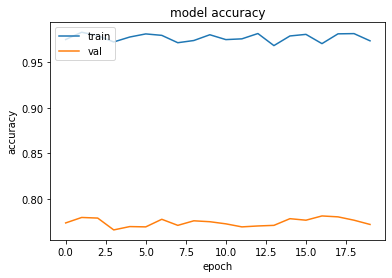

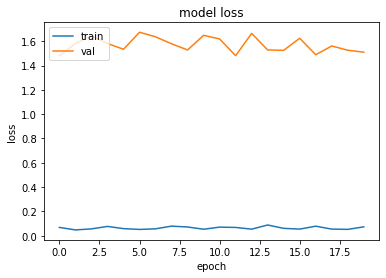

In [ ]:
generate_plots(history=history_2)

In [ ]:
model_2.evaluate(x_test, y_test)

94/94 [==============================] - 1s 5ms/step - loss: 1.2165 - accuracy: 0.7817


[1.2165448665618896, 0.7816666960716248]

Compared to the previous accuracy from `model` we recieved an increase from 
.7703 to .7817 by 
1. adding depth to the network 
2. adding dropout layers 
3. changing the optimizer
4. adjusting the number of epochs

Saving model to drive

In [ ]:
def load_model(path):
    return tf.keras.models.load_model(path)

In [ ]:
model_2.save(r'/content/drive/MyDrive/variables/my_model_2.h5')

In [ ]:
test_model_load = load_model(path=r'/content/drive/MyDrive/variables/my_model_2.h5')

In [ ]:
test_model_load.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 56)                7224      
                                                                 
 dense_22 (Dense)            (None, 3)                

In [ ]:
test_model_load.evaluate(x_test, y_test)

94/94 [==============================] - 3s 3ms/step - loss: 1.2165 - accuracy: 0.7817


[1.2165449857711792, 0.7816666960716248]

Can confirm that loading a saved model works with the function `load_model`

# Problem 3) Spam Email Data

### Loading data

In [ ]:
def load_spam_data(path='/content/drive/MyDrive/variables/spambase.data'):
    '''Loads, parses, and pre-processes the data to prepare it for training, validation, and testing'''
    #path must point to the spambase.data file
    
    df = pd.read_csv(path, header=None)

    #Want to make sure there are no missing values
    assert df.isna().sum().sum() == 0, 'There are missing values, you must take care of them before continuing'

    #renaming column
    df.rename(columns={57:'is_spam'}, inplace=True)

    #split into X and y
    X, y = df.drop(['is_spam'], axis=1), df['is_spam']

    #Split data from X, y into training, validation, and testing (70, 20, 10 split, respectively).
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.90, random_state = 1)

    #Now from this, we will split the X_train, y_train AGAIN to get X_train, y_train, x_val, y_val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.75, random_state = 1)

    print(f'Size of X_train: {len(X_train)}')
    print(f'Size of y_train: {len(y_train)}')
    print('---------------------------------')
    print(f'Size of X_val: {len(X_val)}')
    print(f'Size of y_val: {len(y_val)}')
    print('---------------------------------')
    print(f'Size of X_test: {len(X_test)}')
    print(f'Size of y_test: {len(y_test)}')

    # Let's normalize the features now
    norm = Normalizer()
    X_train = pd.DataFrame(norm.fit_transform(X_train))
    X_val = pd.DataFrame(norm.transform(X_val))
    X_test = pd.DataFrame(norm.transform(X_test))

    #Return the train, val, and test sets
    return X_train, y_train, X_val, y_val, X_test, y_test
    


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_spam_data(path='/content/drive/MyDrive/variables/spambase.data')

Size of X_train: 3105
Size of y_train: 3105
---------------------------------
Size of X_val: 1035
Size of y_val: 1035
---------------------------------
Size of X_test: 461
Size of y_test: 461


### Model Development

In [ ]:
def model_spam():
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(56, activation='relu', input_shape=(np.shape(X_train)[1],)))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [ ]:
model_spambase = model_spam()
model_spambase.summary()
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_spambase.compile(optimizer=opt,loss="binary_crossentropy",metrics=["binary_accuracy"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 56)                3248      
                                                                 
 dense_15 (Dense)            (None, 32)                1824      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_spambase.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                   validation_data=(X_val,y_val))

Epoch 1/100
98/98 [==============================] - 2s 8ms/step - loss: 0.5106 - binary_accuracy: 0.7198 - val_loss: 0.4990 - val_binary_accuracy: 0.7246
Epoch 2/100
98/98 [==============================] - 0s 4ms/step - loss: 0.4205 - binary_accuracy: 0.8087 - val_loss: 0.3968 - val_binary_accuracy: 0.8029
Epoch 3/100
98/98 [==============================] - 0s 4ms/step - loss: 0.3467 - binary_accuracy: 0.8461 - val_loss: 0.3873 - val_binary_accuracy: 0.8097
Epoch 4/100
98/98 [==============================] - 0s 4ms/step - loss: 0.3210 - binary_accuracy: 0.8583 - val_loss: 0.2813 - val_binary_accuracy: 0.9092
Epoch 5/100
98/98 [==============================] - 0s 4ms/step - loss: 0.3117 - binary_accuracy: 0.8715 - val_loss: 0.2883 - val_binary_accuracy: 0.8889
Epoch 6/100
98/98 [==============================] - 0s 4ms/step - loss: 0.2798 - binary_accuracy: 0.8808 - val_loss: 0.2686 - val_binary_accuracy: 0.8976
Epoch 7/100
98/98 [==============================] - 0s 4ms/step - los

### Model Evaluation

In [ ]:
def generate_plots(history):
    #accuracies
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

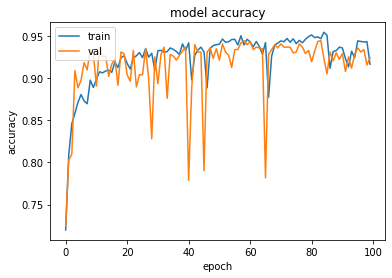

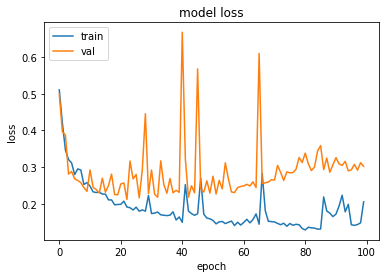

In [ ]:
generate_plots(history=history)

In [ ]:
model_spambase.evaluate(X_test, y_test)

15/15 [==============================] - 0s 5ms/step - loss: 0.5168 - binary_accuracy: 0.9111


[0.516808271408081, 0.9110628962516785]

We recieved 91.1% accuracy. There's some over-fitting.
Let's add dropout layers and tune the optimizer / learning rate and model to see if we can get an improvement

In [ ]:
def model_spam_2():
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(32, activation='relu', input_shape=(np.shape(X_train)[1],)))

    model.add(layers.Dropout(rate=.10))

    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dropout(rate=.10))

    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [ ]:
model_spam_2 = model_spam_2()

model_spam_2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                1856      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Changing the learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.015)

#Compiling the model
model_spam_2.compile(optimizer=opt, loss="binary_crossentropy", metrics=["binary_accuracy"])

history_2 = model_spam_2.fit(X_train,
                    y_train,
                    epochs=50, #reduced the epochs
                    batch_size= 32, #reduced the batch_size
                    validation_data=(X_val,y_val))

Epoch 1/50
98/98 [==============================] - 1s 5ms/step - loss: 0.1424 - binary_accuracy: 0.9436 - val_loss: 0.3155 - val_binary_accuracy: 0.9275
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1436 - binary_accuracy: 0.9411 - val_loss: 0.3314 - val_binary_accuracy: 0.9275
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1737 - binary_accuracy: 0.9324 - val_loss: 0.3006 - val_binary_accuracy: 0.9333
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1487 - binary_accuracy: 0.9404 - val_loss: 0.3091 - val_binary_accuracy: 0.9333
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1402 - binary_accuracy: 0.9440 - val_loss: 0.2991 - val_binary_accuracy: 0.9362
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1379 - binary_accuracy: 0.9472 - val_loss: 0.2986 - val_binary_accuracy: 0.9420
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.15

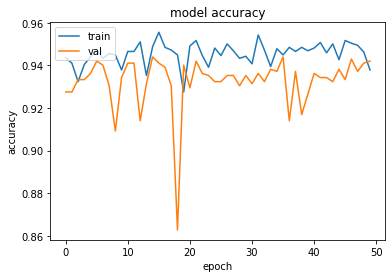

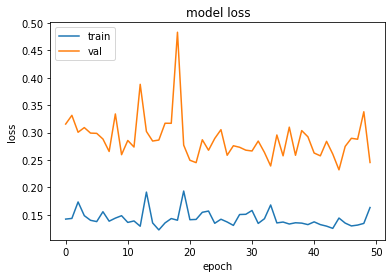

In [ ]:
generate_plots(history=history_2)

In [ ]:
model_spam_2.evaluate(X_test, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.6039 - binary_accuracy: 0.9349


[0.6039056181907654, 0.9349240660667419]

Good improvement by some simple hyperparameter optimization. Brought the binary accuracy from 91.1% to 93.49%.

### Saving / Loading model (jump to this cell to save or load a model AFTER loading in the data)

In [ ]:
def load_model(path):
    return tf.keras.models.load_model(path)

In [ ]:
model_spam_2.save(r'/content/drive/MyDrive/variables/spambase_model_2.h5')

In [ ]:
model_spam_2_loadtest = load_model(path='/content/drive/MyDrive/variables/spambase_model_2.h5')

In [ ]:
model_spam_2_loadtest.evaluate(X_test, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.6039 - binary_accuracy: 0.9349


[0.6039056181907654, 0.9349240660667419]

# Problem 4) Crime Data Analysis

Based on the dataset information from the UCI ML Repo website, we can see that the last column is the target objective column and hence is our 'y' variable.

### Loading and pre-processing data

In [ ]:
def load_crime_data(path='/content/drive/MyDrive/variables/communities.data'):
    df = pd.read_csv(path, header=None)

    #goal / predicting var
    df.rename(columns={127:'ViolentCrimesPerPop'}, inplace=True)

    #renaming column
    df.rename(columns={3:'county_names'}, inplace=True)

    #need to replace '?' with nulls
    df = df.replace('?', np.nan)

    #analyzing missing values
    print(f'There are {sum(df.isna().sum(axis=0) / len(df) > .80)} columns that have over 80 percent of their values as NaN')
    print(f'There are {sum(df.isna().sum(axis=0) / len(df) > .60)} columns that have over 60 percent of their values as NaN')
    print(f'There are {sum(df.isna().sum(axis=0) / len(df) > .50)} columns that have over 50 percent of their values as NaN')
    print(f'There are {sum(df.isna().sum(axis=0) / len(df) > .001)} columns that have atleast some values as NaN')

    #To combat the issue of missing values, we'll resort to dropping all columns with missing values as the majority of the columns
    #with missing values have a LOT of missing values (over 50 percent missing). 

    # Get the columns that need to be dropped
    cols_to_drop = df.columns[df.isna().sum(axis=0) > 0.]
    df = df.drop(labels=cols_to_drop, axis = 1) #perform actual dropping

    #Next we need to categorically encode the text from column 3, the county names
    print(f'There are a total of {np.shape(df.county_names.unique())[0]} unique county names in the county_names column')
    
    #Due to the large amount of unique county names, encoding them is going to become problematic since it'll drastically blow up the data. Further, if each column (basically) has a unique
    #County name, then unless there is another model that is used in an ensemble method which has value towards each county name, the county names would be somewhat not as important.
    #To better justify why I am dropping the entire column imagine there are 100 rows and one of the columns has an ID feature, and practically each ID is unique. If we include that
    #ID feature in our model when we train, then #1 it most likely will lead to collinearity and #2 it simply won't hold much value when trying to fit a decision boundary for that feature.

    #Dropping the county names column
    
    df = df.drop(labels=['county_names'], axis=1)

    #ensuring missing values are taken care of
    assert df.isna().sum().sum() == 0, 'There are still missing values (this should not be the case, go back and ensure all missing values are handled)'

    #Split into X, y
    X, y = df.drop(['ViolentCrimesPerPop'], axis=1), df['ViolentCrimesPerPop']

    #Split data from X, y into training, validation, and testing (70, 20, 10 split, respectively).
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.90, random_state = 1)

    #Now from this, we will split the X_train, y_train AGAIN to get X_train, y_train, x_val, y_val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.75, random_state = 1)
    
    print('---------------------------------')
    print(f'Size of X_train: {len(X_train)}')
    print(f'Size of y_train: {len(y_train)}')
    print('---------------------------------')
    print(f'Size of X_val: {len(X_val)}')
    print(f'Size of y_val: {len(y_val)}')
    print('---------------------------------')
    print(f'Size of X_test: {len(X_test)}')
    print(f'Size of y_test: {len(y_test)}')

    # Let's normalize the features now
    norm = Normalizer()
    X_train = pd.DataFrame(norm.fit_transform(X_train))
    X_val = pd.DataFrame(norm.transform(X_val))
    X_test = pd.DataFrame(norm.transform(X_test))

    #Return the train, val, and test sets
    return X_train, np.array(y_train), X_val, np.array(y_val), X_test, np.array(y_test)

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_crime_data()

There are 22 columns that have over 80 percent of their values as NaN
There are 22 columns that have over 60 percent of their values as NaN
There are 24 columns that have over 50 percent of their values as NaN
There are 24 columns that have atleast some values as NaN
There are a total of 1828 unique county names in the county_names column
---------------------------------
Size of X_train: 1345
Size of y_train: 1345
---------------------------------
Size of X_val: 449
Size of y_val: 449
---------------------------------
Size of X_test: 200
Size of y_test: 200


### Model Development & Training

In [ ]:
def model_crime():

    model = tf.keras.models.Sequential()

    model.add(layers.Dense(32,activation='relu',input_shape=(X_train.shape[1],)))

    model.add(layers.Dense(32,activation='relu'))

    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

    model.summary()
    return model

In [ ]:
model_crime = model_crime()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                3264      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_crossval(model, X_train, y_train, X_val, y_val, k, num_epochs):
    #sample = len(X_train)//k
    #scores = []
    #losses_val = np.empty(shape=(0, num_epochs))
    losses_val = []
    mae_val = []
    

    #Split the X_train, y_train, X_val, y_val
    X_train_folds = np.array_split(X_train, k)
    y_train_folds = np.array_split(y_train, k)
    X_val_folds = np.array_split(X_val, k)
    y_val_folds = np.array_split(y_val, k)

    for i in range(k):
        print(f'--------------Currently on fold {i+1}--------------')
        
        #fit the model and collect the history
        history = model.fit(X_train_folds[i], y_train_folds[i], epochs=num_epochs, batch_size=16, verbose=0, validation_data=(X_val_folds[i],y_val_folds[i]))
        # losses_val = np.append(losses_val, np.array(history.history['val_loss']), axis=0)
        #print(history.history.keys())
        losses_val.append(history.history['val_loss'])
        mae_val.append(history.history['val_mae'])
        #print(losses_val)
        #print(np.array(history.history['val_loss']))
        
    return losses_val, mae_val

In [ ]:
num_epochs=75
losses_val, mae_val = train_crossval(model_crime, X_train, y_train, X_val, y_val, k=5, num_epochs=num_epochs)

--------------Currently on fold 1--------------
--------------Currently on fold 2--------------
--------------Currently on fold 3--------------
--------------Currently on fold 4--------------
--------------Currently on fold 5--------------


In [ ]:
def plot_validation_curves(val_arr, title:str, ylabel:str, num_epochs=num_epochs):
    # Average the losses and plot over the number of epochs
    val_arr = np.array(val_arr)
    print(np.shape(val_arr))

    #Calculate the average over the COLUMNS to get the average of the k-fold cross validation errors
    mean_kfold_val = np.mean(val_arr, axis=0)

    #Plot it w/ number of epochs
    plt.plot(range(1,num_epochs+1), mean_kfold_val)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)

(5, 75)


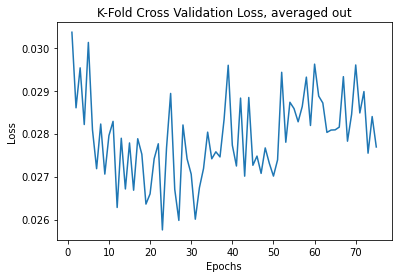

In [ ]:
plot_validation_curves(val_arr=losses_val, title='K-Fold Cross Validation Loss, averaged out', ylabel='Loss')

(5, 75)


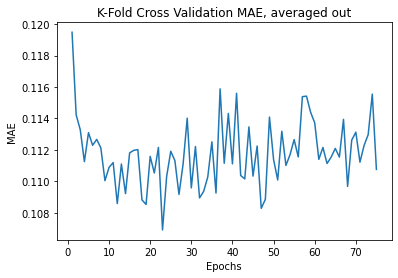

In [ ]:
plot_validation_curves(val_arr=mae_val, title='K-Fold Cross Validation MAE, averaged out', ylabel='MAE')

We can see that the model begins to overfit at approximately num_epochs=20 - 25

With that in mind, we'll re-train the model to prevent over-fitting and then finally evaluate the models performance using the testing set. I'll also try some optimization techniques to help reduce over-fitting

In [ ]:
def model_crime_2_edited():

    model = tf.keras.models.Sequential()

    model.add(layers.Dense(64,activation='relu',input_shape=(X_train.shape[1],)))

    model.add(layers.Dropout(rate=.10))

    model.add(layers.Dense(32,activation='relu'))

    model.add(layers.Dropout(rate=.10))

    model.add(layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.015)
    model.compile(optimizer=opt,loss='mse',metrics=['mae'])

    model.summary()
    return model

In [ ]:
model_crime_2 = model_crime_2_edited()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                6528      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_crime = model_crime_2.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0196 - mae: 0.0989 - val_loss: 0.0229 - val_mae: 0.1090
Epoch 2/50
85/85 [==============================] - 0s 4ms/step - loss: 0.0204 - mae: 0.0992 - val_loss: 0.0252 - val_mae: 0.1236
Epoch 3/50
85/85 [==============================] - 0s 4ms/step - loss: 0.0216 - mae: 0.1036 - val_loss: 0.0224 - val_mae: 0.1090
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0204 - mae: 0.0981 - val_loss: 0.0219 - val_mae: 0.1019
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0202 - mae: 0.1006 - val_loss: 0.0243 - val_mae: 0.1019
Epoch 6/50
85/85 [==============================] - 0s 4ms/step - loss: 0.0221 - mae: 0.1049 - val_loss: 0.0232 - val_mae: 0.1030
Epoch 7/50
85/85 [==============================] - 0s 4ms/step - loss: 0.0202 - mae: 0.0978 - val_loss: 0.0235 - val_mae: 0.1070
Epoch 8/50
85/85 [==============================] - 0s 4ms/step - loss: 0.0193 - mae: 0.09

In [ ]:
print(history_crime.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


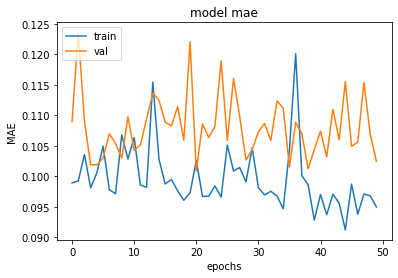

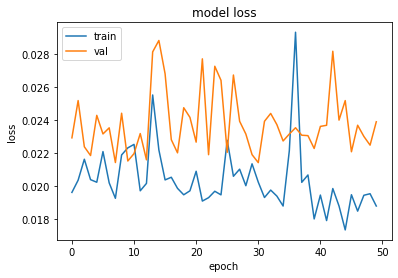

In [ ]:
def generate_plots_crime(history):

    #MAE
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('MAE')
    plt.xlabel('epochs')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

generate_plots_crime(history=history_crime)

In [ ]:
model_crime_2.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0191 - mae: 0.0926


[0.0190601609647274, 0.09259180724620819]

Success! With the help of k-fold cross validation and hyperparameter optimization we brought the MAE down to around ~.093. If you look back and analyze the loss-curves from K-fold cross val we had MAE of approximately ~.106 at its lowest.

### Saving / Loading model

In [ ]:
def load_model(path):
    return tf.keras.models.load_model(path)

In [ ]:
model_crime_2.save(r'/content/drive/MyDrive/variables/model_crime_2.h5')

In [ ]:
model_crime_2_loadtest = load_model(path='/content/drive/MyDrive/variables/model_crime_2.h5')
model_crime_2_loadtest.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0191 - mae: 0.0926


[0.0190601609647274, 0.09259180724620819]

Good, you can successfully load and save it using this.